In [1]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Data Preprocessing and Feature Engineering
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import ItalianStemmer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score


def labels_to_ints(labels):
    return np.array(list(map(lambda x : 1 if x == "pos" else 0, labels)))

def ints_to_labels(labels):
    return list(map(lambda x : "pos" if x == 1 else "neg", labels))

In [2]:
dev_df = pd.read_csv("datasets/development.csv")
X_dev = dev_df.loc[:, 'text']
y_dev = labels_to_ints(dev_df.loc[:, 'class'])

ev_df = pd.read_csv("datasets/evaluation.csv")
X_ev = ev_df.loc[:, 'text']

X_dev.shape[0] + X_ev.shape[0]

41077

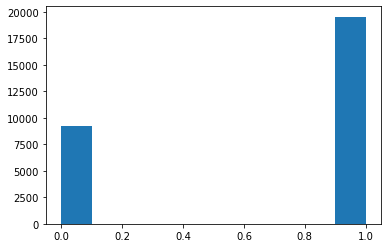

In [3]:
plt.hist(y_dev)
plt.show()

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'url', text) # remove URLs
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "email", text) # remove email
    text = re.sub(r'@([^\s]+)', r'\1', text) # remove eventually @<word>
    text = re.sub(r'#([^\s]+)', r'\1', text) # remove eventually hashtag 
    text = re.sub(r'[#@]', " ", text) # remove eventually isolated @#
    text = re.sub("'", "' ", text)  #insert a space in every word with the <'> in order to be catched by tokenizer and filtered
    text = re.sub(r"([.]*)([0-9]+)([.]*)", r"\0 \1", text) # i.e ciao123come20va -> ciao come va
    text = re.sub("([*.\-/+])", " ", text) # remove special characters from words of kind "..<word>" "***" "-<word>" "..<word>"
    return text

class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = ItalianStemmer()
    
    def __call__(self, text):
        lemmas = []
        regex = re.compile("[0-9]+")
        stopwords = sw.words('italian') + ['quantum', "url", "email", 'sempre', 'avra', 'avro', 'fara', 'faro', 'perche', 'sara', 'saro', 'stara', 'staro']
        text = preprocess_text(text)
        for t in word_tokenize(text):
            t = t.strip()
            if t not in string.punctuation and 3 < len(t) < 16 and not regex.match(t) and t not in stopwords:
                lemma = self.stemmer.stem(t)
                lemmas.append(lemma)
        return lemmas
    

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, shuffle=True, test_size=0.25)


In [53]:
from sklearn.decomposition import TruncatedSVD
pipeline = Pipeline([
    ('bow',CountVectorizer(input='content', min_df=10, tokenizer=LemmaTokenizer(), ngram_range=(2,2))),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(C=10, max_iter=180, n_jobs=8)),
])

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)
print(classification_report(y_predict,y_test))
print(confusion_matrix(y_predict,y_test))
print(f1_score(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2185
           1       0.97      0.95      0.96      5004

    accuracy                           0.94      7189
   macro avg       0.93      0.94      0.93      7189
weighted avg       0.94      0.94      0.94      7189

[[2023  162]
 [ 266 4738]]
0.9567851373182552


In [52]:
from sklearn.decomposition import TruncatedSVD
pipeline = Pipeline([
    ('bow',CountVectorizer(input='content', min_df=10, tokenizer=LemmaTokenizer(), ngram_range=(2, 2))),
    ('tfidf', TfidfTransformer()),
    ('pca', TruncatedSVD(n_components=6941)),
    ('classifier', LogisticRegression(C=10, max_iter=180, n_jobs=8)),
])
pipeline.fit(X_dev, y_dev)
y_pred_ev = pipeline.predict(X_ev)
pipeline['pca'].explained_variance_ratio_.sum()

0.7626348747011125

In [51]:
cum_variance = np.cumsum(pipeline['pca'].explained_variance_ratio_)
ind = np.argmax(cum_variance > .8)
ind

0

In [50]:
with open("datasets/sample_submission8.csv", "w", encoding="utf8") as sub:
    sub.write("Id,Predicted\n")
    for i, label in enumerate(ints_to_labels(y_pred_ev)):
        sub.write(f"{i},{label}\n")
 